# Full code

In [62]:
#!/usr/bin/env python3
# ──────────────────────────────────────────────────────────
#  Inference + Error-heatmap visualisation for IMU→Skeleton
# ──────────────────────────────────────────────────────────
import os, glob, numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ───────────────────────── Dataset & helpers ─────────────
def extractMoCap(data):
    time = data['time']                               # (T,)
    torso = np.stack([np.zeros_like(data['leftShoulderPosRel']),
                      data['leftShoulderPosRel'],
                      data['rightShoulderPosRel'],
                      np.zeros_like(data['rightShoulderPosRel'])], axis=1)
    left_arm  = np.stack([data['leftShoulderPosRel'],
                          data['leftElbowPosRel'],
                          data['leftWristPosRel'],
                          data['leftFingerPosRel']], axis=1)
    right_arm = np.stack([data['rightShoulderPosRel'],
                          data['rightElbowPosRel'],
                          data['rightWristPosRel'],
                          data['rightFingerPosRel']], axis=1)
    return time, torso, left_arm, right_arm            # time, (T,4,3), (T,4,3), (T,4,3)

def extractIMU(data):
    time = data['time']
    return (time,
            data['accelerationLeftLoc'],  data['accelerationRightLoc'],
            data['gyroLeftLoc'],          data['gyroRightLoc'])

class CustomDataset(Dataset):
    def __init__(self, filenames): self.fnames = filenames
    def __len__(self): return len(self.fnames)
    def __getitem__(self, idx):
        f = self.fnames[idx]
        d = np.load(f)
        time, torso, left_arm, right_arm = extractMoCap(d)
        _, l_acc, r_acc, l_gyro, r_gyro  = extractIMU(d)
        mocap = np.concatenate([left_arm, right_arm], axis=1)          # (T, 8, 3)
        imu   = np.stack([l_acc, r_acc, l_gyro, r_gyro], axis=1)       # (T, 4, 3)
        return {'time': torch.tensor(time,   dtype=torch.float32),
                'mocap':torch.tensor(mocap, dtype=torch.float32),
                'imu':  torch.tensor(imu,   dtype=torch.float32)}

def collate_fn(batch):
    max_len = max(len(x['time']) for x in batch)
    def pad(seq, tgt_len, pad_last):
        pad_len = tgt_len - len(seq)
        return torch.cat([seq, pad_last.repeat(pad_len,1,1)])
    out = {'mocap':[], 'imu':[], 'time':batch[0]['time'][:max_len]}
    for s in batch:
        out['mocap'].append(pad(s['mocap'], max_len, s['mocap'][-1:]))
        acc  = pad(s['imu'][:,[0,1]], max_len, s['imu'][-1:,[0,1]])
        gyro = pad(s['imu'][:,[2,3]], max_len,
                   torch.zeros_like(s['imu'][-1:,[2,3]]))
        out['imu'].append(torch.cat([acc, gyro], dim=1))
    out['mocap'] = torch.stack(out['mocap'])           # (B,T,8,3)
    out['imu']   = torch.stack(out['imu'])             # (B,T,4,3)
    return out

# ───────────────────────── Model ─────────────────────────
class SimpleNN(nn.Module):
    def __init__(self, input_size=4*3, hidden_size=8*3, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
    def forward(self, x):                     # (B,T,4,3)
        x = x.flatten(2)                      # (B,T,12)
        out, _ = self.lstm(x)                  # (B,T,24)
        return out

# ───────────────────────── Model (Convtransformer, Patrick) ─────────────────────────
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math
class ConvTransformer(nn.Module):
    """
    Conv + Transformer encoder for IMU→MoCap regression.
    Input:  x of shape (B, window_size, input_dim)
    Output: Tensor of shape (B, window_size * 8 * 3)
    """
    def __init__(
        self,
        input_dim: int,              # e.g. 12
        transformer_dim: int,        # d_model, e.g. 64
        window_size: int,            # sequence length
        nhead: int,                  # attention heads, e.g. 8
        dim_feedforward: int,        # transformer FF size, e.g. 256
        transformer_dropout: float,  # dropout rate, e.g. 0.1
        transformer_activation: str, # "gelu" or "relu"
        num_encoder_layers: int,     # number of Transformer layers, e.g. 6
        encode_position: bool = False
    ):
        super().__init__()
        d_model = transformer_dim
        W = window_size

        # 1) Conv1d stack to embed raw IMU → (B, d_model, W)
        self.input_proj = nn.Sequential(
            nn.Conv1d(input_dim,   d_model, 1), nn.GELU(),
            nn.Conv1d(d_model,     d_model, 1), nn.GELU(),
            nn.Conv1d(d_model,     d_model, 1), nn.GELU(),
            nn.Conv1d(d_model,     d_model, 1), nn.GELU(),
        )
        
        # 2) Positional embedding (optional)
        self.encode_position = encode_position
        if encode_position:
            # one position vector per timestep
            self.position_embed = nn.Parameter(torch.randn(W, 1, d_model))

        # 3) Transformer encoder
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=transformer_dropout,
            activation=transformer_activation
        )
        self.transformer_encoder = TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers,
            norm=nn.LayerNorm(d_model)
        )

        # 4) Regression head (token‑wise)
        self.regression_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 4),
            nn.GELU(),
            nn.Dropout(transformer_dropout),
            nn.Linear(d_model // 4, 8 * 3)
        )

        # 5) Xavier init
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: FloatTensor of shape (B, window_size, 4, 3) OR already flattened (B, W, C)
        returns: FloatTensor of shape (B, W*8*3)
        """
        # if it's still (B, W, 4, 3), flatten sensor×axis → channels
        if x.dim() == 4:
            B, W, S, A = x.shape   # S=4 sensors, A=3 axes
            x = x.reshape(B, W, S * A)

        # ── embed + reshape ───────────────────────────────
        x = x.transpose(1, 2)         # (B, C, W)
        x = self.input_proj(x)       # (B, d_model, W)
        x = x.permute(2, 0, 1)       # (W, B, d_model)

        if self.encode_position:
            x = x + self.position_embed

        # ── transformer ─────────────────────────────────────
        x = self.transformer_encoder(x)  # (W, B, d_model)
        x = x.permute(1, 0, 2)           # (B, W, d_model)

        # ── regression head ──────────────────────────────────
        B, W, D = x.shape
        x = x.reshape(B * W, D)          # (B*W, d_model)
        out = self.regression_head(x)    # (B*W, 8*3)
        out = out.view(B, W * 8 * 3)     # (B, W*8*3)
        return out

# ───────────────────────── Model (BiLSTM, Abhay) ─────────────────────────
class BiLSTM(nn.Module):
    def __init__(self, input_size=4*3, hidden_size=12, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        # hidden_size*2 = 24 = 8 joints × 3 coords
    def forward(self, x):
        # x: (N, T, 4, 3)
        x = x.flatten(2)              # → (N, T, 12)
        out, _ = self.lstm(x)         # → (N, T, 24)
        return out

# ───────────────────────── Model (Transformer, Abhay) ─────────────────────────
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)          # (max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x):
        # x: (T, N, d_model) → add (T, d_model)
        seq_len = x.size(0)
        return x + self.pe[:seq_len].unsqueeze(1)
    
class TransformerEncoderModel(nn.Module):
    def __init__(self,
                 input_size=4*3,   # 12
                 d_model=64,
                 nhead=8,
                 num_layers=2,
                 dim_feedforward=256,
                 dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=10000)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True    # ← enable batch-first mode
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        # project back to 8 joints ×3 coords = 24 dims
        self.output_proj = nn.Linear(d_model, 8*3)
    def forward(self, x):
        # x: (N, T, 4, 3)
        N, T, _, _ = x.shape
        x = x.flatten(2)               # → (N, T, 12)
        x = self.input_proj(x)         # → (N, T, d_model)
        # Transformer expects (S, N, E) where S=sequence length
        x = x.permute(1, 0, 2)         # → (T, N, d_model)
        x = self.pos_encoder(x)        # + positional encoding
        x = self.transformer(x)        # → (T, N, d_model)
        x = x.permute(1, 0, 2)         # → (N, T, d_model)
        x = self.output_proj(x)        # → (N, T, 24)
        return x
# ───────────────────────── Heat-maps ─────────────────────
def plot_joint_error_heatmap(pred, gt, path=None):
    errs = np.linalg.norm(pred-gt, axis=-1)    # (T,J)
    fig,ax=plt.subplots(figsize=(8,4))
    im = ax.imshow(errs.mean(0)[None,:], cmap='Reds', aspect='auto')
    ax.set_xlabel('Joint Index'); ax.set_yticks([]); ax.set_title('Mean Joint Errors')
    cbar=plt.colorbar(im,ax=ax); cbar.set_label('MPJPE (m)',rotation=270,labelpad=15)
    if path: os.makedirs(os.path.dirname(path),exist_ok=True); plt.savefig(path,dpi=300,bbox_inches='tight')
    plt.show()

def plot_frame_error_heatmap(pred, gt, path=None):
    errs = np.linalg.norm(pred-gt, axis=-1)    # (T,J)
    fig,ax=plt.subplots(figsize=(8,4))
    im = ax.imshow(errs.mean(1)[:,None].T,cmap='Blues',aspect='auto')
    ax.set_xticks(np.linspace(0,len(errs)-1,10,dtype=int))
    ax.set_xlabel('Frame Index'); ax.set_ylabel('Error'); ax.set_title('Mean Frame Errors')
    cbar=plt.colorbar(im,ax=ax); cbar.set_label('MPJPE (m)',rotation=270,labelpad=15)
    if path: os.makedirs(os.path.dirname(path),exist_ok=True); plt.savefig(path,dpi=300,bbox_inches='tight')
    plt.show()

# Visualize

In [63]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 10000

def visualize_skeleton_comparison(ground_truth, predictions, frame_idx=0, title='Skeleton Comparison'):
    """
    Visualize ground truth vs predicted skeletons
    
    Args:
        ground_truth: Tensor of shape (seq_len, 8, 3) or array-like
        predictions: Tensor of shape (seq_len, 8, 3) or array-like
        frame_idx: Index of the frame to visualize
        title: Plot title
    """
    # Convert to numpy if tensors
    if isinstance(ground_truth, torch.Tensor):
        ground_truth = ground_truth.detach().cpu().numpy()
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    
    # Extract specific frame
    gt_frame = ground_truth[frame_idx]  # Shape: (8, 3)
    pred_frame = predictions[frame_idx]  # Shape: (8, 3)
    
    # Define the connections for visualization (joint indices)
    left_arm_connections = [(0, 1), (1, 2), (2, 3)]  # Shoulder -> Elbow -> Wrist -> Finger
    right_arm_connections = [(4, 5), (5, 6), (6, 7)]  # Shoulder -> Elbow -> Wrist -> Finger
    
    fig = plt.figure(figsize=(18, 6))
    
    # Setup 3 views: front (XZ), side (YZ), top (XY)
    views = [(0, 2, 'Front View (XZ)'), (1, 2, 'Side View (YZ)'), (0, 1, 'Top View (XY)')]
    
    for i, (dim1, dim2, view_title) in enumerate(views):
        ax = fig.add_subplot(1, 3, i+1)
        ax.set_title(f"{view_title}")
        
        # Plot ground truth left arm
        for start_idx, end_idx in left_arm_connections:
            ax.plot([gt_frame[start_idx, dim1], gt_frame[end_idx, dim1]], 
                    [gt_frame[start_idx, dim2], gt_frame[end_idx, dim2]], 
                    'b-', linewidth=3, alpha=0.7)
        
        # Plot ground truth right arm
        for start_idx, end_idx in right_arm_connections:
            ax.plot([gt_frame[start_idx, dim1], gt_frame[end_idx, dim1]], 
                    [gt_frame[start_idx, dim2], gt_frame[end_idx, dim2]], 
                    'g-', linewidth=3, alpha=0.7)
        
        # Plot predicted left arm
        for start_idx, end_idx in left_arm_connections:
            ax.plot([pred_frame[start_idx, dim1], pred_frame[end_idx, dim1]], 
                    [pred_frame[start_idx, dim2], pred_frame[end_idx, dim2]], 
                    'b--', linewidth=2)
        
        # Plot predicted right arm
        for start_idx, end_idx in right_arm_connections:
            ax.plot([pred_frame[start_idx, dim1], pred_frame[end_idx, dim1]], 
                    [pred_frame[start_idx, dim2], pred_frame[end_idx, dim2]], 
                    'g--', linewidth=2)
        
        # Plot joints
        ax.scatter(gt_frame[:4, dim1], gt_frame[:4, dim2], c='blue', s=50, label='GT Left Arm')
        ax.scatter(gt_frame[4:, dim1], gt_frame[4:, dim2], c='green', s=50, label='GT Right Arm')
        ax.scatter(pred_frame[:4, dim1], pred_frame[:4, dim2], c='cyan', s=30, label='Pred Left Arm')
        ax.scatter(pred_frame[4:, dim1], pred_frame[4:, dim2], c='lime', s=30, label='Pred Right Arm')
        
        # Set the aspect ratio to be equal
        ax.set_aspect('equal')
        
        # Set labels
        ax.set_xlabel(f"Dimension {dim1}")
        ax.set_ylabel(f"Dimension {dim2}")
        
        # Add legend
        if i == 0:
            ax.legend(loc='upper left')  # or 'best' or 'lower left', etc.

        
        # Add grid
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.85)
    
    return fig

In [64]:
import matplotlib.animation as animation
from IPython.display import HTML

def create_skeleton_animation(ground_truth, predictions, save_path=None, fps=30, duration=None):
    """
    Create animation comparing ground truth and predicted skeletons
    
    Args:
        ground_truth: Tensor of shape (seq_len, 8, 3) or array-like
        predictions: Tensor of shape (seq_len, 8, 3) or array-like
        save_path: Path to save the animation. If None, the animation is not saved
        fps: Frames per second
        duration: Duration of the animation in seconds. If None, all frames are used
    
    Returns:
        Animation object that can be displayed in a notebook
    """
    # Convert to numpy if tensors
    if isinstance(ground_truth, torch.Tensor):
        ground_truth = ground_truth.detach().cpu().numpy()
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    
    # Define the connections for visualization
    left_arm_connections = [(0, 1), (1, 2), (2, 3)]  # Shoulder -> Elbow -> Wrist -> Finger
    right_arm_connections = [(4, 5), (5, 6), (6, 7)]  # Shoulder -> Elbow -> Wrist -> Finger
    
    # Calculate the total number of frames to display
    total_frames = len(ground_truth)
    if duration is not None:
        total_frames = min(total_frames, int(duration * fps))
    
    # Create figure and axes
    fig = plt.figure(figsize=(18, 6))
    axes = [fig.add_subplot(1, 3, i+1) for i in range(3)]
    
    # Set view titles
    view_titles = ['Front View (XZ)', 'Side View (YZ)', 'Top View (XY)']
    views = [(0, 2), (1, 2), (0, 1)]  # Dimensions to plot for each view
    
    for ax, title in zip(axes, view_titles):
        ax.set_title(title)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
    
    # Set axis limits based on the data range with some padding
    pad = 0.1
    min_vals = np.min(np.concatenate([ground_truth, predictions]), axis=(0, 1))
    max_vals = np.max(np.concatenate([ground_truth, predictions]), axis=(0, 1))
    range_vals = max_vals - min_vals
    min_vals -= range_vals * pad
    max_vals += range_vals * pad
    
    for i, ax in enumerate(axes):
        dim1, dim2 = views[i]
        ax.set_xlim(min_vals[dim1], max_vals[dim1])
        ax.set_ylim(min_vals[dim2], max_vals[dim2])
    
    # Initialize lines and points for ground truth
    gt_left_lines = [[ax.plot([], [], 'b-', linewidth=3, alpha=0.7)[0] for _ in left_arm_connections] for ax in axes]
    gt_right_lines = [[ax.plot([], [], 'g-', linewidth=3, alpha=0.7)[0] for _ in right_arm_connections] for ax in axes]
    gt_left_points = [ax.scatter([], [], c='blue', s=50, label='GT Left Arm') for ax in axes]
    gt_right_points = [ax.scatter([], [], c='green', s=50, label='GT Right Arm') for ax in axes]
    
    # Initialize lines and points for predictions
    pred_left_lines = [[ax.plot([], [], 'b--', linewidth=2)[0] for _ in left_arm_connections] for ax in axes]
    pred_right_lines = [[ax.plot([], [], 'g--', linewidth=2)[0] for _ in right_arm_connections] for ax in axes]
    pred_left_points = [ax.scatter([], [], c='cyan', s=30, label='Pred Left Arm') for ax in axes]
    pred_right_points = [ax.scatter([], [], c='lime', s=30, label='Pred Right Arm') for ax in axes]
    
    # Add legend to the first axis
    axes[0].legend(loc='upper right')
    
    # Frame counter text
    frame_text = fig.text(0.5, 0.95, '', ha='center')
    
    def init():
        """Initialize the animation"""
        for ax_gt_left_lines in gt_left_lines:
            for line in ax_gt_left_lines:
                line.set_data([], [])
        
        for ax_gt_right_lines in gt_right_lines:
            for line in ax_gt_right_lines:
                line.set_data([], [])
        
        for ax_pred_left_lines in pred_left_lines:
            for line in ax_pred_left_lines:
                line.set_data([], [])
        
        for ax_pred_right_lines in pred_right_lines:
            for line in ax_pred_right_lines:
                line.set_data([], [])
        
        for point in gt_left_points + gt_right_points + pred_left_points + pred_right_points:
            point.set_offsets(np.empty((0, 2)))
        
        frame_text.set_text('')
        
        return (sum(gt_left_lines, []) + sum(gt_right_lines, []) + 
                sum(pred_left_lines, []) + sum(pred_right_lines, []) + 
                gt_left_points + gt_right_points + pred_left_points + pred_right_points + 
                [frame_text])
    
    def update(frame_idx):
        """Update the animation for a specific frame"""
        gt_frame = ground_truth[frame_idx]
        pred_frame = predictions[frame_idx]
        
        # Update ground truth lines and points
        for i, ax in enumerate(axes):
            dim1, dim2 = views[i]
            
            # Update ground truth left arm
            for j, (start_idx, end_idx) in enumerate(left_arm_connections):
                gt_left_lines[i][j].set_data(
                    [gt_frame[start_idx, dim1], gt_frame[end_idx, dim1]],
                    [gt_frame[start_idx, dim2], gt_frame[end_idx, dim2]]
                )
            
            # Update ground truth right arm
            for j, (start_idx, end_idx) in enumerate(right_arm_connections):
                gt_right_lines[i][j].set_data(
                    [gt_frame[start_idx, dim1], gt_frame[end_idx, dim1]],
                    [gt_frame[start_idx, dim2], gt_frame[end_idx, dim2]]
                )
            
            # Update predicted left arm
            for j, (start_idx, end_idx) in enumerate(left_arm_connections):
                pred_left_lines[i][j].set_data(
                    [pred_frame[start_idx, dim1], pred_frame[end_idx, dim1]],
                    [pred_frame[start_idx, dim2], pred_frame[end_idx, dim2]]
                )
            
            # Update predicted right arm
            for j, (start_idx, end_idx) in enumerate(right_arm_connections):
                pred_right_lines[i][j].set_data(
                    [pred_frame[start_idx, dim1], pred_frame[end_idx, dim1]],
                    [pred_frame[start_idx, dim2], pred_frame[end_idx, dim2]]
                )
            
            # Update points
            gt_left_points[i].set_offsets(gt_frame[:4, [dim1, dim2]])
            gt_right_points[i].set_offsets(gt_frame[4:, [dim1, dim2]])
            pred_left_points[i].set_offsets(pred_frame[:4, [dim1, dim2]])
            pred_right_points[i].set_offsets(pred_frame[4:, [dim1, dim2]])
        
        # Update frame counter
        frame_text.set_text(f'Frame: {frame_idx+1}/{total_frames}')
        
        return (sum(gt_left_lines, []) + sum(gt_right_lines, []) + 
                sum(pred_left_lines, []) + sum(pred_right_lines, []) + 
                gt_left_points + gt_right_points + pred_left_points + pred_right_points + 
                [frame_text])
    
    # Create the animation
    ani = animation.FuncAnimation(
        fig, update, frames=total_frames, init_func=init, 
        blit=True, interval=1000/fps, repeat=True
    )
    
    # Save animation if a path is provided
    if save_path is not None:
        # Save .mp4
        writer = animation.FFMpegWriter(fps=fps)
        ani.save(save_path + '.mp4', writer=writer)
        
        # Save .gif
        ani.save(save_path + '.gif', writer='pillow')
        
        print(f"Animation saved to {save_path}.mp4 and {save_path}.gif")
    
    plt.close()
    return ani

In [65]:
def visualize_model_predictions(model, test_dataloader, num_samples=1, save_animations=False):
    """
    Visualize model predictions for a few test samples in a controlled manner.
    
    This updated version shows:
      - Only one sample per batch (as set by num_samples).
      - Two static frames: the first and the last frame.
      - One animation per sample showing the full sequence.
    
    For each sample, the function produces:
      1. Two static visualization figures with three subplots each (Front View, Side View, and Top View),
         comparing the ground truth and predicted skeletons.
      2. An animation that displays the entire motion sequence for that sample.
    """
    model.eval()
    
    with torch.no_grad():
        # Process only the first batch to reduce computation
        for i, batch in enumerate(test_dataloader):
            # Run the model on the input IMU data and reshape prediction to match mocap data shape
            outputs = model(batch['imu'])
            outputs_reshaped = outputs.view(*batch['mocap'].shape)
            
            # For the static visualization and animation, process only the first 'num_samples'
            for j in range(min(num_samples, outputs_reshaped.size(0))):
                # Select two key frames: the first frame and the last frame
                frame_indices = [0, outputs_reshaped.size(1)-1]
                for frame_idx in frame_indices:
                    # Visualize static comparison for the selected frames
                    fig = visualize_skeleton_comparison(
                        batch['mocap'][j], outputs_reshaped[j], 
                        frame_idx=frame_idx, 
                        title=f'Sample {j+1}, Frame {frame_idx}'
                    )
                    # Save figure if needed, or display it
                    print("Saved figure for sample", j+1, "at frame", frame_idx)
                    plt.savefig(f'./result/skeleton_comparison_sample_{j+1}_frame_{frame_idx}.png')
                    plt.close(fig)
                
                # Create an animation for the full motion sequence of this sample.
                # The animation uses a specified frame rate (fps) and shows all frames.
                ani = create_skeleton_animation(
                    batch['mocap'][j], outputs_reshaped[j],
                    save_path=f'./result/{model.__class__.__name__}_sample{j+1}_anim',
                    fps=30
                )

                # If you are using a Jupyter Notebook, you can display the animation using:
                from IPython.display import HTML
                display(HTML(ani.to_jshtml()))
            
            # Process only the first batch to avoid visualizing too much data
            break

# Run main

In [69]:
! pip install imageio
! pip install ffmpeg

In [70]:
! ffmpeg -version

zsh:1: command not found: ffmpeg


Saved figure for sample 1 at frame 0
Saved figure for sample 1 at frame 1168


FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'

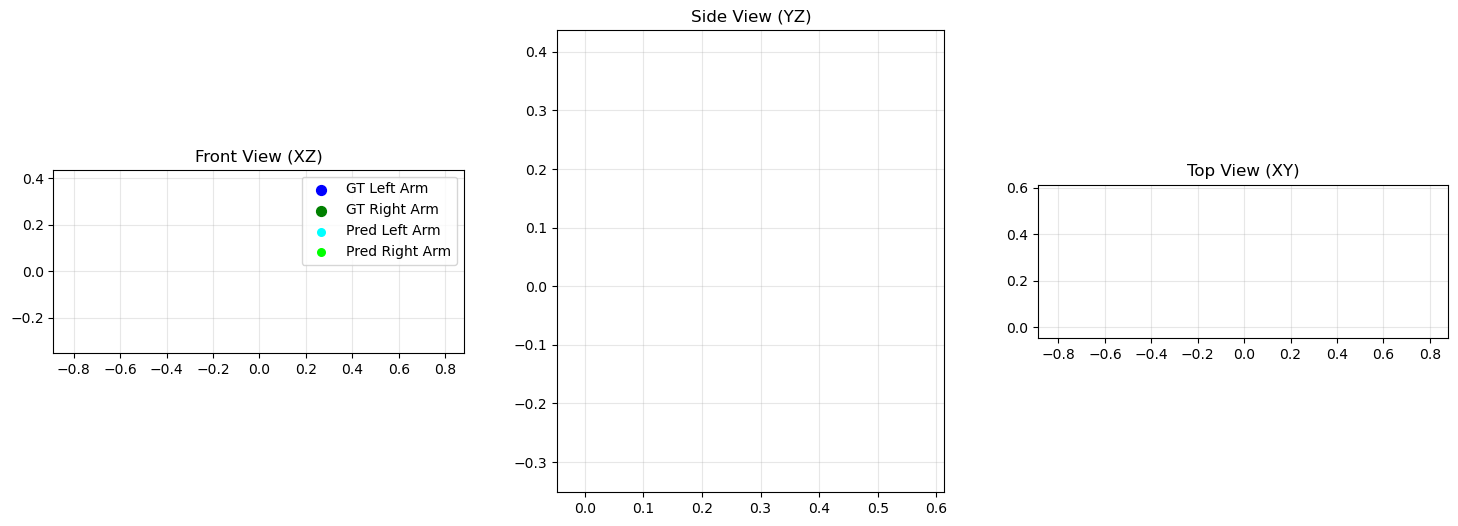

In [67]:
# ───────────────────────── Main ──────────────────────────
def main():
    import glob
    import torch
    import numpy as np
    from torch.utils.data import DataLoader

    # -------- data --------
    npz_dir   = '../data'                     # TODO: update if needed
    fnames    = glob.glob(f'{npz_dir}/*.npz')
    assert fnames, f'No .npz files in {npz_dir}'
    
    subjects  = np.unique([f.split('_')[-2] for f in fnames])
    np.random.seed(42)
    perm      = np.random.permutation(len(subjects))
    test_sub  = subjects[perm[-1:]]
    test_files = [f for f in fnames if f.split('_')[-2] in test_sub]

    test_dataset    = CustomDataset(test_files)
    test_dataloader = DataLoader(test_dataset, batch_size=10, collate_fn=collate_fn)

    # -------- model & ckpt --------
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # --------- [1] BiLSTM -----------------
    model = BiLSTM(input_size=12, hidden_size=12, num_layers=2).to(device)
    
    # --------- [2] Transformer -----------------
    '''
    model = TransformerEncoderModel(
        input_size=12,
        d_model=64,
        nhead=8,
        num_layers=2,
        dim_feedforward=256,
        dropout=0.1
    )
    '''
    # --------- [3] ConvTransformer -----------------
    '''
    model = ConvTransformer(
         input_dim=12,
         transformer_dim=64,
         window_size=120,
         nhead=8,
         dim_feedforward=256,
         transformer_dropout=0.1,
         transformer_activation="gelu",
         num_encoder_layers=6,
         encode_position=True
    '''
    
    ckpt   = '../models/BiLSTM_epoch_10.pth'  # TODO: checkpoint path
    model.load_state_dict(torch.load(ckpt, map_location=device))
    model.eval()

    # -------- inference on one batch --------
    batch   = next(iter(test_dataloader))
    imu_in  = batch['imu'].to(device)         # (B,T,4,3)
    gt_full = batch['mocap']                  # (B,T,8,3) still on CPU
    with torch.no_grad():
        out = model(imu_in).cpu()             # (B, T, 24)
        pred_full = out.view(out.size(0), out.size(1), 8, 3)  # (B, T, 8, 3)

    # -------- visualize one sample --------
    pred = pred_full[0].numpy()               # (T,8,3)
    gt   = gt_full[0].numpy()
    #plot_joint_error_heatmap(pred, gt, './result/joint_error_heatmap.png')
    #plot_frame_error_heatmap(pred, gt, './result/frame_error_heatmap.png')
    #print('✓ Heat-maps saved in ./result/')

    # -------- visualize all predictions with custom function --------
    import os
    os.makedirs('./result', exist_ok=True)
    visualize_model_predictions(model, test_dataloader)

if __name__ == '__main__':
    main()
